In [20]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

## Import jeu de train, test, validation

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten

# Définir les chemins des répertoires contenant vos images d'entraînement, de test et de validation
train_dir = 'C:\\Users\\Utilisateur\\Documents\\12_non supervise\\Alien_Predator\\Train'
test_dir = 'C:\\Users\\Utilisateur\\Documents\\12_non supervise\\Alien_Predator\\Test'
validation_dir = 'C:\\Users\\Utilisateur\\Documents\\12_non supervise\\Alien_Predator\\Validation'


# Définir la taille des images d'entrée et d'autres paramètres de prétraitement
img_size = (150, 150)
batch_size = 494


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Créez un générateur d'images avec prétraitement pour l'ensemble d'entraînement (train)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Créez un générateur d'images avec prétraitement pour l'ensemble de validation
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Créez un générateur d'images avec prétraitement pour l'ensemble de test
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Utilisez les générateurs pour charger et prétraiter les ensembles de formation (train), de validation et de test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=495,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=200,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=200,
    class_mode='binary'
)


Found 494 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [23]:
class_names = list(train_generator.class_indices.keys())
class_names

['Alien', 'Predator']

In [24]:
# Extraction des données d'entraînement
X_train, y_train = next(train_generator)

# Extraction des données de test
X_test, y_test = next(test_generator)

# Extraction des données de validation
X_val, y_val = next(validation_generator)
X_train.shape, y_train.shape

((494, 150, 150, 3), (494,))

# Charger le modèle VGG16 pré-entraîné et extraire les caractéristiques des images

In [25]:
# Charger le modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))



# Extraire les caractéristiques des images
train_features = base_model.predict(train_generator, steps=len(train_generator), verbose=1)
validation_features = base_model.predict(validation_generator, steps=len(validation_generator), verbose=1)
test_features = base_model.predict(test_generator, steps=len(test_generator), verbose=1)


1/1 [==============================] - 12s 12s/step


### Aplatir les caractéristiques extraites

In [26]:
# Aplatir les caractéristiques extraites
train_features_flatten = train_features.reshape(train_features.shape[0], -1)
validation_features_flatten = validation_features.reshape(validation_features.shape[0], -1)
test_features_flatten = test_features.reshape(test_features.shape[0], -1)

In [27]:
train_features.shape, train_features_flatten.shape


((494, 4, 4, 512), (494, 8192))

## Compiler et entrainer le modele MLP avec les caracteristique extrait de VGG16

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

mlp_model = keras.Sequential()
mlp_model.add(layers.Dense(units=256, activation='relu', input_dim=4 * 4 * 512))
mlp_model.add(layers.Dense(units=1, activation='sigmoid'))


In [29]:
# Compiler le modèle MLP
mlp_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [30]:
# Entraîner le modèle vgg sur les caractéristiques extraites
history = mlp_model.fit(
    train_features_flatten,
    y_train,
    batch_size = 494,
    epochs=100,
    validation_data=(validation_features_flatten, y_val),
    verbose=1
)



Epoch 1/100
1/1 [==============================] - 1s 786ms/step - loss: 17.0135 - accuracy: 0.4980 - val_loss: 7.4892 - val_accuracy: 0.3950
Epoch 2/100
1/1 [==============================] - 0s 78ms/step - loss: 8.0195 - accuracy: 0.4008 - val_loss: 8.7297 - val_accuracy: 0.4450
Epoch 3/100
1/1 [==============================] - 0s 74ms/step - loss: 7.8896 - accuracy: 0.4474 - val_loss: 7.9639 - val_accuracy: 0.4900
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 6.3115 - accuracy: 0.5223 - val_loss: 5.0057 - val_accuracy: 0.5900
Epoch 5/100
1/1 [==============================] - 0s 74ms/step - loss: 2.9199 - accuracy: 0.6377 - val_loss: 2.6781 - val_accuracy: 0.6550
Epoch 6/100
1/1 [==============================] - 0s 75ms/step - loss: 1.0187 - accuracy: 0.8097 - val_loss: 2.2204 - val_accuracy: 0.7300
Epoch 7/100
1/1 [==============================] - 0s 75ms/step - loss: 0.9302 - accuracy: 0.8117 - val_loss: 2.3481 - val_accuracy: 0.7450
Epoch 8/100
1/1 [=

In [31]:
# Évaluer le modèle MLP sur les caractéristiques de test
test_loss, test_accuracy = mlp_model.evaluate(test_features_flatten, y_test)
print("Test accuracy:", test_accuracy)


7/7 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.9100
Test accuracy: 0.9100000262260437


### Visualize training results

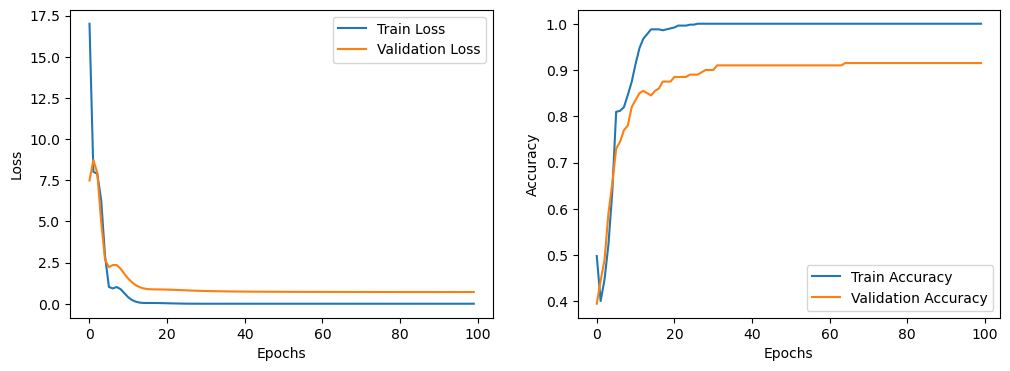

In [32]:
import matplotlib.pyplot as plt


# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 4))

# Courbes de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbes de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Évaluez le modèle sur l'ensemble de test

In [33]:
# Évaluer le modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = mlp_model.evaluate(train_features_flatten, y_train)
print("Train accuracy:", train_accuracy)

# Évaluer le modèle sur l'ensemble de validation
validation_loss, validation_accuracy = mlp_model.evaluate(validation_features_flatten, y_val)
print("Validation accuracy:", validation_accuracy)

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = mlp_model.evaluate(test_features_flatten, y_test)
print("Test accuracy:", test_accuracy)


16/16 [==============================] - 0s 3ms/step - loss: 1.9560e-05 - accuracy: 1.0000
Train accuracy: 1.0
7/7 [==============================] - 0s 6ms/step - loss: 0.7105 - accuracy: 0.9150
Validation accuracy: 0.9150000214576721
7/7 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.9100
Test accuracy: 0.9100000262260437


In [34]:
# Obtenir les prédictions sur l'ensemble d'entraînement
y_train_pred = mlp_model.predict(train_features_flatten)

# Obtenir les prédictions sur l'ensemble de validation
y_val_pred = mlp_model.predict(validation_features_flatten)

# Obtenir les prédictions sur l'ensemble de test
y_test_pred = mlp_model.predict(test_features_flatten)


7/7 [==============================] - 0s 4ms/step


In [35]:
# Conversion des probabilités
y_pred_train_prob= [1 if prob > 0.5 else 0 for prob in np.ravel(y_train_pred)]
print(y_pred_train_prob[:10])

y_pred_test_prob= [1 if prob > 0.5 else 0 for prob in np.ravel(y_test_pred)]
print(y_pred_test_prob[:10])

y_pred_val_prob= [1 if prob > 0.5 else 0 for prob in np.ravel(y_val_pred)]
print(y_pred_val_prob[:10])

[0, 0, 1, 0, 0, 0, 0, 1, 1, 1]
[1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1, 1, 0]


In [36]:
# Matrice de confusion jeu d'apprentissage
print("Matrice de confusion jeu d'apprentissage ")
print(confusion_matrix(y_train, y_pred_train_prob))

# Matrice de confusion jeu de test
print("Matrice de confusion jeu de test")
print(confusion_matrix(y_test, y_pred_test_prob))

# Matrice de confusion jeu de test
print("Matrice de confusion jeu de test")
print(confusion_matrix(y_val, y_pred_val_prob))

Matrice de confusion jeu d'apprentissage 
[[247   0]
 [  0 247]]
Matrice de confusion jeu de test
[[95  5]
 [13 87]]
Matrice de confusion jeu de test
[[95  5]
 [12 88]]


In [37]:
print(classification_report(y_test, y_pred_test_prob))


              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       100
         1.0       0.95      0.87      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

